In [2]:
a = "aa"
b = "bb"
print(a+b+'cc')

aabbcc


In [2]:
import sys
import os 
print(os.getcwd())
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
sys.path.append('..')

import torch 


/workspace/project/misc


In [3]:
print(os.getcwd())
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

import torchmetrics

In [4]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [5]:
from parameters import get_parameters

VIDEO_LENGTH = ['1', '2', '3']
VIDEO_FRAME = ['8', '16', '32']

opt, _ = get_parameters()
opt.num_workers = 4
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

# opt.clip_duration = 2
# opt.uniform_temporal_subsample_num = 30
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
# opt.train_path = '/workspace/data/split_pad_dataset_512/fold3/'

opt.transfor_learning = True
opt.pre_process_flag = True

DATA_PATH = opt.split_pad_data_path

In [6]:
opt.train_path = os.path.join(DATA_PATH, 'cord_test')

opt.clip_duration = int(1)
opt.uniform_temporal_subsample_num = int(8)

ckpt_path = '/workspace/project/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt'

print('#' * 50)
print('the data path: %s' % opt.train_path)
print('ckpt: %s' % ckpt_path)
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.val_dataloader()

##################################################
the data path: /workspace/data/split_pad_dataset_512/cord_test
ckpt: /workspace/project/logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../logs/resnet/1119_1_8_resnet_depth50/flod2/checkpoints/epoch=11-val_loss=0.63-val_acc=0.8926.ckpt`
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/split_pad_dataset_512/cord_test
##################################################


In [7]:
import numpy as np 



from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import visualization as viz

# Grad CAM pytorch
use pytorch_grad_cam api to make visilization.

In [8]:
#   {
#      'video': <video_tensor>,     # Shape: (C, T, H, W)
#      'audio': <audio_tensor>,     # Shape: (S)
#      'label': <action_label>,     # Integer defining class annotation
#      'video_name': <video_path>,  # Video file path stem
#      'video_index': <video_id>,   # index of video used by sampler
#      'clip_index': <clip_id>      # index of clip sampled within video
#   }
batch = next(iter(test_data))
video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num
print("video_path:", batch['video_name'][0])
print("label:", batch['label'])


i=0
input_tensor = video[i].unsqueeze(dim=0).cuda()
inp_label = label[i]

video.shape, label.shape, input_tensor.shape, inp_label

video_path: 20171211_full_lat_49.mp4
label: tensor([0, 0, 0, 0, 0, 0, 1, 1])


(torch.Size([8, 3, 8, 224, 224]),
 torch.Size([8]),
 torch.Size([1, 3, 8, 224, 224]),
 tensor(0))

In [9]:
from pytorch_grad_cam import GradCAM, HiResCAM, FullGrad, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# guided grad cam method
target_layer = [model.model.blocks[-2].res_blocks[-1]]
# target_layer = [ model.model.blocks[-2]]

cam = LayerCAM(model, target_layer)
y_hat = model.model(video)
y_hat_sigmoid = torch.sigmoid(y_hat)
pred_labels = torch.where(y_hat_sigmoid >= 0.5, torch.tensor(1), torch.tensor(0))
print(pred_labels)
out_label = pred_labels[0]
print(out_label)

targets = [ClassifierOutputTarget(-1)]

grayscale_cam = cam(input_tensor, aug_smooth=True, eigen_smooth=True)

type(grayscale_cam), grayscale_cam.shape

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1]])
tensor([0])


(numpy.ndarray, (1, 8, 224, 224))

In [50]:
inp_tensor = input_tensor.squeeze().permute(1,2,3,0)[2].cpu().detach().numpy()
inp_tensor.shape, type(inp_tensor), grayscale_cam.shape

((224, 224, 3), numpy.ndarray, (1, 8, 224, 224))

In [36]:
cam_map = grayscale_cam.mean(axis=1).squeeze()
# cam_map = grayscale_cam[:,:,:,0].squeeze()
cam_map = np.expand_dims(cam_map, 2)

cam_map.shape, type(cam_map)

((224, 224, 1), numpy.ndarray)

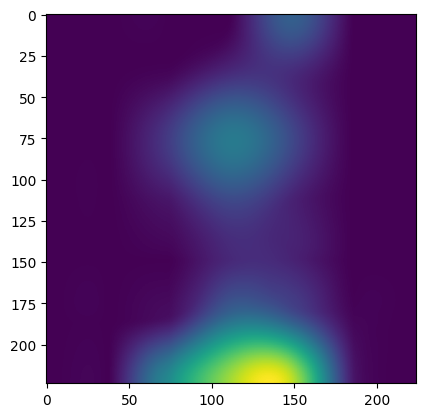

In [37]:
import matplotlib.pyplot as plt 

plt.imshow(cam_map)

In [1]:
# use captum visual method
figure, axis = viz.visualize_image_attr_multiple(
        cam_map,
        inp_tensor,
        methods=['original_image', 'blended_heat_map'],
        signs=['all', 'positive'],
        show_colorbar=True,
        outlier_perc=1, 
        cmap='jet',
        titles = ['original image', 'GradCAM++, true label %s, pred label %s' % (int(inp_label), int(out_label))]
    )

NameError: name 'viz' is not defined

In [39]:
input_tensor.shape

torch.Size([1, 3, 8, 224, 224])

In [40]:
from torchvision.io import write_video

write_video('1s.mp4', video_array=input_tensor.squeeze().permute(1,2,3,0).detach().cpu(), fps=10)

In [41]:
batch['video_name'][0]

'20171211_full_lat_49.mp4'